In [1]:
# Packages -- use ´Pkg.add(XXX)´ to install a package if you do not have it yet
using Pkg
using Random
using Statistics
using StatsBase
using DataFrames
using Distributions
using LinearAlgebra
using ScikitLearn

In [2]:
using ScikitLearn: fit!, predict, @sk_import
@sk_import model_selection: cross_val_score
@sk_import metrics: accuracy_score 
@sk_import linear_model: LogisticRegression
@sk_import tree: DecisionTreeClassifier

┌ Warning: Module model_selection has been ported to Julia - try `import ScikitLearn: CrossValidation` instead
└ @ ScikitLearn.Skcore /home/dgribel/.julia/packages/ScikitLearn/bo2Pt/src/Skcore.jl:140


PyObject <class 'sklearn.tree._classes.DecisionTreeClassifier'>

In [3]:
# Create synthetic data from a Mixture of Gaussians
# You can play with the parameters Σ and μ to test different degrees of overlapping

# Seed for random data generation and random dataset spliting the into training and testing
MY_SEED = 1
Random.seed!(MY_SEED)

# Number of samples
n = 10000

# Number of groups (classes)
k = 2

# Number of dimensions (features)
d = 6

# Mixing coefficient -- probability of sampling from each component
pi = [ 1/k for i = 1:k ]

# Set the a-priori membership (ground-truth)
label = StatsBase.sample(0:(k-1), Weights(pi), n)

# Common co-variance for all Gaussian components
Σ = Diagonal(repeat([2.], d))

# Mean values for the first Guassian component
μ1 = [4., 3., 4., 3., 6., 5.]

# Mean values for the second Guassian component
μ2 = [3., 2., 5., 3., 4., 4.]

distributions = DiagNormal[]

# Adding Gaussian components
push!(distributions, MvNormal(μ1, Σ))
push!(distributions, MvNormal(μ2, Σ))

data = Array{Float64}(undef, n, d)

# Sample each data from a Gaussian component
[ data[i,:] = rand(distributions[ label[i] + 1 ], 1) for i = 1:n ]

# Create dataframe
df = DataFrame(data)

,x1,x2,x3,x4,x5,x6
,Float64,Float64,Float64,Float64,Float64,Float64
1,5.56333,2.77873,4.78555,3.3175,2.77281,6.68794
2,4.65245,2.62907,4.03449,3.66123,5.55873,4.50497
3,4.66063,3.12674,2.73802,4.47055,6.29215,5.88915
4,2.78379,2.81046,3.09766,3.7892,8.26149,4.14564
5,4.13779,2.30521,5.04599,3.24328,6.22653,4.20234
6,6.1162,4.27623,2.66362,2.2024,6.45185,6.84047
7,2.57072,2.73544,6.0384,1.79811,3.46622,4.95677
8,1.61498,-1.07675,4.90796,5.19607,3.60735,3.23281
9,4.41111,2.07137,3.48372,2.74928,7.0508,4.76278


In [4]:
using RCall
@rlibrary ggplot2

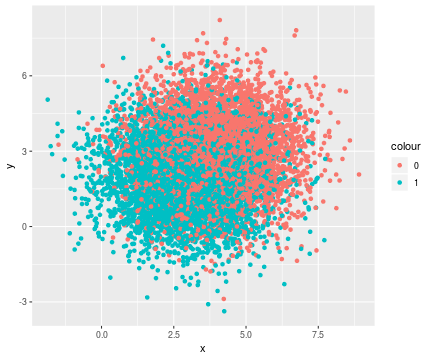

RObject{VecSxp}


In [5]:
# Plot the samples in 2D
ggplot(df, aes(x = df.x1, y = df.x2, color = string.(label))) + geom_point()

In [6]:
function train(model, L, U, y_l)
    # Fit the model
    fit!(model, L, y_l)
    
    # Make predictions on training set: 
    predictions = predict(model, L)
    
    # Calculate training accuracy
    accuracy = accuracy_score(predictions, y_l)
    # println("\nAccuracy: ", accuracy)
    
    # K-fold cross-validation 
    cross_score = cross_val_score(model, L, y_l, cv = 5)
    
    # Calculate cross-validation score 
    # println("Cross-validation score: ", mean(cross_score), " >> ", cross_score)
    
    # Fit the model
    fit!(model, L, y_l)
    
    # Make predictions on testing (unlabeled) dataset
    pred = predict_proba(model, U)
    
    # Return predictions
    return pred
 end

train (generic function with 1 method)

In [7]:
function informativeness(U, membership, idx_u)
    nb_u = size(U)[1]
    info_score = zeros(Float64, nb_u)
    # Calculate the score (entropy) for each sample in the unlabeled set
    [ info_score[i] = entropy(membership[i,:]) for i = 1:nb_u ]
    # Get the top-k most informative samples
    b = sortperm(-info_score)[1:batch]
    return idx_u[b]
end

informativeness (generic function with 1 method)

In [8]:
function initial_indices(initial_size, n)
    Random.seed!(MY_SEED)
    # Randomly select the samples to be included in the initial labeled set
    idx_l = rand(1:n, initial_size)
    # Fill the unlabeled set with the remaining samples
    idx_u = setdiff(1:n, idx_l)
    return idx_l, idx_u
end

initial_indices (generic function with 1 method)

In [9]:
function split_datasets(idx_l, idx_u)
    # Split the dataset into labeled (training) and unlabeled (testing) sets
    L = X[idx_l, :]
    U = X[idx_u, :]
    y_l = y[idx_l]
    y_u = y[idx_u]
    return L, U, y_l, y_u
end

split_datasets (generic function with 1 method)

In [10]:
Random.seed!(MY_SEED)

# Percentage of samples selected for training
PERC_TRAIN = .8

# Total number of samples
n = size(df)[1]

# Size of the initial labeled set -- randomly choose S samples
S = 30

# Total budget for samples annotation
budget = [60, 80, 100, 120, 140, 160, 180, 200, 220, 240]

# Batch size of Active learning
batch = 5

# Create the model
model = LogisticRegression()
# model = DecisionTreeClassifier()

# Select features for prediction
predictor_var = [:x1, :x2, :x3, :x4, :x5, :x6]

# Set the number of samples used for training
size_train = Int(floor(PERC_TRAIN*n))

# Number of tests -- each iteration considers a different set for train/test
NUM_IT = 10

10

In [11]:
### Active learning tests
avg_acc_al = Float64[]
X = []
y = []

for b = 1:length(budget)
    
    # Average accuracy of all tests
    avg_acc = 0.
    
    for it = 1:NUM_IT
        Random.seed!(MY_SEED + it)

        # Select samples for train/test
        idx_train = StatsBase.sample(1:n, size_train, replace = false)
        idx_test = setdiff(1:n, idx_train)

        # Training dataset
        y = label[idx_train] 
        X = convert(Array, df[idx_train, predictor_var])

        # Testing dataset
        y2 = label[idx_test]
        X2 = convert(Array, df[idx_test, predictor_var])

        # Select the initial indices for traininig
        idx_l, idx_u = initial_indices(S, size_train)

        # Split the dataset into training (labeled) and testing (unlabeled)
        L, U, y_l, y_u = split_datasets(idx_l, idx_u)

        # Train and classify
        pred_u = train(model, L, U, y_l)

        # Number of iterations in the Active learning framework
        nb_iterations = Int((budget[b] - S)/batch)

        for i = 1:nb_iterations-1
            # Collect informativeness measure of each sample
            r = informativeness(U, pred_u, idx_u)

            # Update the training (labeled) indices with the most informative samples
            idx_l = vcat(idx_l, r)

            # Update the unlabeled indices
            idx_u = setdiff(idx_u, r)

            # Split the dataset into training (labeled) and testing (unlabeled)
            L, U, y_l, y_u = split_datasets(idx_l, idx_u)

            # Train and classify
            pred_u = train(model, L, U, y_l) 
        end

        # Fit the model
        fit!(model, L, y_l)

        # Predict on testing dataset
        predictions = predict(model, X2)

        # Calculate accuracy on testing dataset
        accuracy = accuracy_score(predictions, y2) 

        # println("Test Accuracy: ", accuracy)

        avg_acc = avg_acc + accuracy
    end
    println("Average Accuracy ACTIVE LEARNING (B = ", budget[b], "): ", avg_acc/NUM_IT)
    push!(avg_acc_al, avg_acc/NUM_IT)
end

Average Accuracy ACTIVE LEARNING (B = 60): 0.8250500000000001
Average Accuracy ACTIVE LEARNING (B = 80): 0.8288999999999997
Average Accuracy ACTIVE LEARNING (B = 100): 0.83295
Average Accuracy ACTIVE LEARNING (B = 120): 0.8384500000000001
Average Accuracy ACTIVE LEARNING (B = 140): 0.8409000000000001
Average Accuracy ACTIVE LEARNING (B = 160): 0.8402
Average Accuracy ACTIVE LEARNING (B = 180): 0.8412499999999999
Average Accuracy ACTIVE LEARNING (B = 200): 0.84195
Average Accuracy ACTIVE LEARNING (B = 220): 0.8432000000000001
Average Accuracy ACTIVE LEARNING (B = 240): 0.8430500000000001


In [12]:
### Standard (static) learning tests
avg_acc_sl = Float64[]
X = []
y = []

for b = 1:length(budget)

    avg_acc = 0.

    for it = 1:NUM_IT
        Random.seed!(MY_SEED + it)

        # Select samples for train/test
        idx_train = StatsBase.sample(1:n, size_train, replace = false)
        idx_test = setdiff(1:n, idx_train)

        # Training dataset
        y = label[idx_train] 
        X = convert(Array, df[idx_train, predictor_var])

        # Testing dataset
        y2 = label[idx_test]
        X2 = convert(Array, df[idx_test, predictor_var])

        # Randomly select B samples from the training dataset to reveal the labels
        idx_train = StatsBase.sample(1:size_train, budget[b], replace = false)
        idx_test  = setdiff(1:size_train, idx_train)

        # Train and classify
        pred = train(model, X[idx_train, :], X[idx_test, :], y[idx_train]) 

        # Fit the model
        fit!(model, X[idx_train, :], y[idx_train])

        # Predict on testing dataset
        predictions = predict(model, X2)

        # Calculate accuracy on testing dataset
        accuracy = accuracy_score(predictions, y2) 

        # println("Test Accuracy: ", accuracy)

        avg_acc = avg_acc + accuracy
    end
    println("Average Accuracy STATIC LEARNING (B = ", budget[b], "): ", avg_acc/NUM_IT)
    push!(avg_acc_sl, avg_acc/NUM_IT)
end

Average Accuracy STATIC LEARNING (B = 60): 0.82555
Average Accuracy STATIC LEARNING (B = 80): 0.83125
Average Accuracy STATIC LEARNING (B = 100): 0.8305
Average Accuracy STATIC LEARNING (B = 120): 0.8342499999999999
Average Accuracy STATIC LEARNING (B = 140): 0.8329000000000001
Average Accuracy STATIC LEARNING (B = 160): 0.8352
Average Accuracy STATIC LEARNING (B = 180): 0.8366
Average Accuracy STATIC LEARNING (B = 200): 0.8371999999999999
Average Accuracy STATIC LEARNING (B = 220): 0.83865
Average Accuracy STATIC LEARNING (B = 240): 0.83765


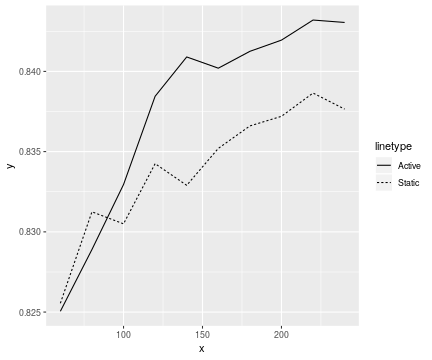

RObject{VecSxp}


In [13]:
# Create the dataframe with the results of Active and Static learning aprroaches
outcome  = DataFrame(
    bud  = vcat(budget, budget),
    algo = vcat(repeat(["Active"], length(budget)), repeat(["Static"], length(budget))),
    acc  = vcat(avg_acc_al, avg_acc_sl))

# Average accuracy of the two techniques as a function of the number of samples used in labeling
ggplot(data = outcome, aes(x = outcome.bud, y = outcome.acc, group = outcome.algo)) +
        geom_line(aes(linetype = outcome.algo))